In [1]:
import math
import argparse
from itertools import chain,combinations
import os
import random
import sys
from collections import Counter
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

from Nash import find_nash_equilibria_v2

In [2]:
rootdir = '../data/HuGaDB'
resultsdir = "../results/HuGaDB"

if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

In [3]:
np.random.seed(42)

### Creating Global Train set and Test set

In [4]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")) for i in range(10)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(os.path.join(rootdir, f"test_{i+1:02d}.csv")) for i in range(10)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)


#### Centralized Training

  0%|          | 0/1 [00:00<?, ?it/s]


Confusion Matrix for Trial 1:
[[11620   151     0     1    59     2   688]
 [  141 11956     0     0    62     2   595]
 [    2     0  7550    24     0    19     0]
 [    1     0    49  1843    40     1     2]
 [   12    11     0    35 26501    36    75]
 [    2     3    61     0    86  2208     2]
 [  921   767     0     1   103     3 36666]]


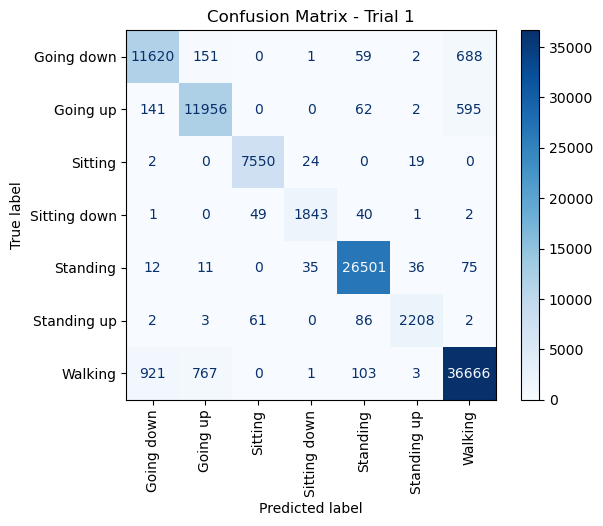

100%|██████████| 1/1 [00:24<00:00, 24.29s/it]

Trial 1/1 - Global test accuracy: 0.9613200261972024


In [5]:
# Parameters
n_trials = 1
n_trees = 10
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []


for trial in tqdm.tqdm(range(n_trials)):

    trial_random_state = random.randint(0, 100)
    

    model = RandomForestClassifier(n_estimators=n_trees, random_state=trial_random_state)
    model.fit(X_train_global, y_train_global)
    

    y_pred = model.predict(X_test_global)
    acc_test = accuracy_score(y_test_global, y_pred)
    

    cm = confusion_matrix(y_test_global, y_pred)
    print(f"\nConfusion Matrix for Trial {trial + 1}:")
    print(cm)
    

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - Trial {trial + 1}")
    plt.show()
    

    results_global.append(acc_test)
    
    print(f"Trial {trial + 1}/{n_trials} - Global test accuracy: {acc_test}")


df_global = pd.DataFrame(results_global, columns=["accuracy"])
df_global.to_csv(os.path.join(resultsdir, "global.csv"), index=False)


#### FL

In [6]:
# Define the DecisionTree class
class DecisionTree:
    def __init__(self, max_depth=None, random_state=None):
        self.max_depth = max_depth
        self.tree_ = None
        self.random_state = random_state

    def fit(self, X, y):
        self.tree_ = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
        self.tree_.fit(X, y)

    def predict(self, X):
        return self.tree_.predict(X)

# Define the FederatedForest class
class FederatedForest:
    def __init__(self):
        self.models = []

    def add_model(self, model):
        self.models.append(model)

    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        predictions = np.array(predictions).T
        y = [np.bincount(row).argmax() for row in predictions]
        return np.array(y)

In [7]:
# Parameters
max_depth = 10
n_clients = 10 
n_trials = 1
random_seed = 42

results = []


for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    np.random.seed(random_seed + trial)

    # Train models for the 10 clients
    client_models = []
    client_local_accuracies = []
    client_global_accuracies = []
    for i in range(n_clients):
        df_train_i = pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")).dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        model = DecisionTree(max_depth=max_depth, random_state=random_seed + trial)
        model.fit(X_train, y_train)
        client_models.append(model)

        # Test locally
        df_test_i = pd.read_csv(os.path.join(rootdir, f"test_{i+1:02d}.csv")).dropna(subset=['act'])
        X_test = df_test_i.drop('act', axis=1)
        y_test = label_encoder.transform(df_test_i['act'])

        # Evaluate globally
        y_pred_global = model.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate models
        forest = FederatedForest()
        for model in included_models:
            forest.add_model(model)

        # Global accuracy
        y_pred_global = forest.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [j + 1 for j in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
        results.append(row)

df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(resultsdir, "combinations_results_with_trials.csv"), index=False)


Trial 1/1


In [8]:
df_results = pd.read_csv(os.path.join(resultsdir, "combinations_results_with_trials.csv"))

In [9]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(10)

Trial  Combination                          Clients  Global Accuracy  \
1020      1   1111111101     [1, 3, 4, 5, 6, 7, 8, 9, 10]         0.874126   
1022      1   1111111111  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]         0.873833   
1021      1   1111111110     [2, 3, 4, 5, 6, 7, 8, 9, 10]         0.870754   
1011      1   1111110100           [3, 5, 6, 7, 8, 9, 10]         0.870558   
1013      1   1111110110        [2, 3, 5, 6, 7, 8, 9, 10]         0.869610   
500       1    111110101            [1, 3, 5, 6, 7, 8, 9]         0.869327   
1019      1   1111111100        [3, 4, 5, 6, 7, 8, 9, 10]         0.869258   
510       1    111111111      [1, 2, 3, 4, 5, 6, 7, 8, 9]         0.868398   
765       1   1011111110        [2, 3, 4, 5, 6, 7, 8, 10]         0.867773   
508       1    111111101         [1, 3, 4, 5, 6, 7, 8, 9]         0.867509   

      Client 1 Accuracy  Client 2 Accuracy  Client 3 Accuracy  \
1020           0.598645           0.446281           0.598665   
1022           0.598645           0.446281           0.598665   
1021           0.598645           0.446281           0.598665   
1011           0.598645           0.446281           0.598665   
1013           0.598645           0.446281           0.598665   
500            0.598645           0.446281           0.598665   
1019           0.598645           0.446281           0.598665   
510            0.598645           0.446281           0.598665   
765            0.598645           0.446281           0.598665   
508            0.598645           0.446281           0.598665   

      Client 4 Accuracy  Client 5 Accuracy  Client 6 Accuracy  \
1020           0.537355           0.686787           0.713825   
1022           0.537355           0.686787           0.713825   
1021           0.537355           0.686787           0.713825   
1011           0.537355           0.686787           0.713825   
1013           0.537355           0.686787           0.713825   
500            0.537355           0.686787           0.713825   
1019           0.537355           0.686787           0.713825   
510            0.537355           0.686787           0.713825   
765            0.537355           0.686787           0.713825   
508            0.537355           0.686787           0.713825   

      Client 7 Accuracy  Client 8 Accuracy  Client 9 Accuracy  \
1020           0.665341           0.721528           0.663923   
1022           0.665341           0.721528           0.663923   
1021           0.665341           0.721528           0.663923   
1011           0.665341           0.721528           0.663923   
1013           0.665341           0.721528           0.663923   
500            0.665341           0.721528           0.663923   
1019           0.665341           0.721528           0.663923   
510            0.665341           0.721528           0.663923   
765            0.665341           0.721528           0.663923   
508            0.665341           0.721528           0.663923   

      Client 10 Accuracy  
1020            0.555254  
1022            0.555254  
1021            0.555254  
1011            0.555254  
1013            0.555254  
500             0.555254  
1019            0.555254  
510             0.555254  
765             0.555254  
508             0.555254

In [10]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

Combination  Trial                          Clients  Global Accuracy
0  0000000010      1                              [2]         0.446281
1  1111111111      1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]         0.873833

#### MLP

In [11]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  
    activation='relu',            
    solver='adam',                
    max_iter=300,           
    random_state=42               
)

In [12]:
def average_parameters(coefs_list, intercepts_list):
    avg_coefs = [np.mean([coef[i] for coef in coefs_list], axis=0) for i in range(len(coefs_list[0]))]
    avg_intercepts = [np.mean([intercept[i] for intercept in intercepts_list], axis=0) for i in range(len(intercepts_list[0]))]
    return avg_coefs, avg_intercepts

#### Centralized Training For MLP

Test Accuracy: 0.9333


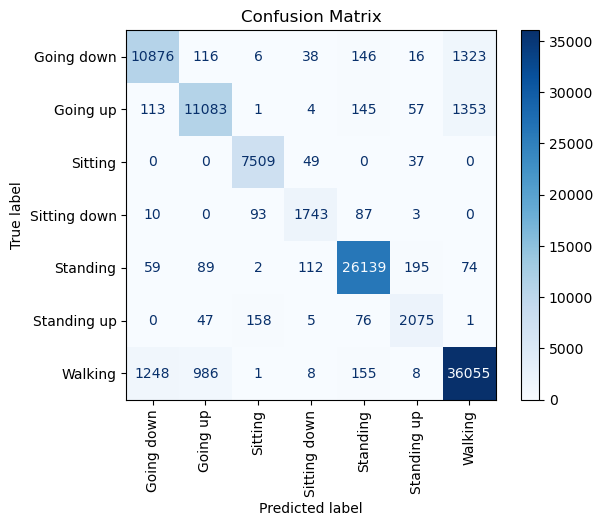

In [13]:

mlp.fit(X_train_global, y_train_global)


y_pred_global = mlp.predict(X_test_global)
accuracy_global = accuracy_score(y_test_global, y_pred_global)

print(f"Test Accuracy: {accuracy_global:.4f}")


conf_matrix = confusion_matrix(y_test_global, y_pred_global)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')


plt.title("Confusion Matrix")
plt.show()


#### FL For MLP

In [14]:
#parameters
mlp_param = {
    "hidden_layer_sizes": (64, 32),
    "activation": "relu",
    "solver": "adam",
    "max_iter": 300, 
    "random_state": 42,
}


mlp_params = {
    "hidden_layer_sizes": (64, 32),
    "activation": "relu",
    "solver": "adam",
    "max_iter": 1, 
    "random_state": 42,
}


In [15]:
results = []
random_seed = 42
n_clients = 10

np.random.seed(random_seed)

# Train models for the 10 clients
client_models = []
client_local_accuracies = []
client_global_accuracies = []


for i in range(n_clients):
    df_train_i = pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")).dropna(subset=['act'])
    X_train = df_train_i.drop('act', axis=1)
    y_train = label_encoder.transform(df_train_i['act'])

    # Train a new MLP model for each client
    model = MLPClassifier(**mlp_param)
    model.fit(X_train, y_train)
    client_models.append(model)

    # for Test locally
    df_test_i = pd.read_csv(os.path.join(rootdir, f"test_{i+1:02d}.csv")).dropna(subset=['act'])
    X_test = df_test_i.drop('act', axis=1)
    y_test = label_encoder.transform(df_test_i['act'])

    # Evaluate locally and store accuracy
    y_pred_local = model.predict(X_test)
    acc_local = accuracy_score(y_test, y_pred_local)
    client_local_accuracies.append(acc_local)

    # Evaluate globally 
    y_pred_global = model.predict(X_test_global)
    acc_global = accuracy_score(y_test_global, y_pred_global)
    client_global_accuracies.append(acc_global)

# Evaluate all combinations
n_combinations = 2 ** n_clients
for i in range(1, n_combinations):
    bin_str = format(i, f'0{n_clients}b')
    client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
    included_models = [client_models[j] for j in client_indices]
    
    if not included_models:
        continue

    # Aggregate model parameters (averaging)
    coefs_list = [model.coefs_ for model in included_models]
    intercepts_list = [model.intercepts_ for model in included_models]
    avg_coefs, avg_intercepts = average_parameters(coefs_list, intercepts_list)

    # Create and initialize the global model
    global_model = MLPClassifier(**mlp_params)

    
    # Dummy fit to initialize
    X_dummy = X_test_global.iloc[:1]
    y_dummy = y_test_global[:1]
    global_model.partial_fit(X_dummy, y_dummy, classes=np.unique(y_test_global))

    # Set the averaged parameters
    global_model.coefs_ = avg_coefs
    global_model.intercepts_ = avg_intercepts

    # Global accuracy
    y_pred_global = global_model.predict(X_test_global)
    acc_global = accuracy_score(y_test_global, y_pred_global)

    row = {
        'Trial': 1,
        'Combination': bin_str,
        'Clients': [j + 1 for j in client_indices], 
        'Global Accuracy': acc_global
    }

    
    for j in range(n_clients):
        row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
    results.append(row)



df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(resultsdir, "mlp_combinations_results.csv"), index=False)


In [25]:
df_results = pd.read_csv(os.path.join(resultsdir, "mlp_combinations_results.csv"))
pad_len = max(df_results['Combination'].apply(lambda x: len(str(x))))
df_results['Combination'] = df_results['Combination'].apply(lambda x: str(x).zfill(pad_len))

In [26]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

Trial Combination Clients  Global Accuracy  Client 1 Accuracy  \
31       1  0000100000     [6]         0.761645           0.601656   
15       1  0000010000     [5]         0.745711           0.601656   
7        1  0000001000     [4]         0.718722           0.601656   
63       1  0001000000     [7]         0.687520           0.601656   
255      1  0100000000     [9]         0.677383           0.601656   

     Client 2 Accuracy  Client 3 Accuracy  Client 4 Accuracy  \
31            0.512683           0.585635           0.718722   
15            0.512683           0.585635           0.718722   
7             0.512683           0.585635           0.718722   
63            0.512683           0.585635           0.718722   
255           0.512683           0.585635           0.718722   

     Client 5 Accuracy  Client 6 Accuracy  Client 7 Accuracy  \
31            0.745711           0.761645            0.68752   
15            0.745711           0.761645            0.68752   
7             0.745711           0.761645            0.68752   
63            0.745711           0.761645            0.68752   
255           0.745711           0.761645            0.68752   

     Client 8 Accuracy  Client 9 Accuracy  Client 10 Accuracy  
31            0.610844           0.677383            0.616025  
15            0.610844           0.677383            0.616025  
7             0.610844           0.677383            0.616025  
63            0.610844           0.677383            0.616025  
255           0.610844           0.677383            0.616025

In [18]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

Combination  Trial Clients  Global Accuracy
0  0000000001      1     [1]         0.601656
1  0000000010      1     [2]         0.512683
2  0001000000      1     [7]         0.687520
3  0010000000      1     [8]         0.610844
4  0100000000      1     [9]         0.677383

In [36]:
ne = "0000000001"

for i in range(pad_len):
    deviation = list(ne)
    if ne[i] != "1":
        deviation[i] = "1"
        deviation = "".join(deviation)
        acc = df_results[df_results["Combination"] == deviation]["Global Accuracy"]

1000000001
0100000001
0010000001
0001000001
0000100001
0000010001
0000001001
0000000101
0000000011
